# FieldTools Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bunzela/FieldTools/blob/main/FieldTools.ipynb)

---
FieldTools.py can be used to calculate electric fields from MD trajectories. The script requires standard MD **trajectory** and **parameter** files as input.
Furthermore a **target** file needs to be provided that specifies the positions at which the field will be calculated.

---     
<font color="red">**Attention: Trajectories must be immaged!**</font>  
<font color="red">FieldTools calculates the fields from the exact location of all atoms in the simulation without considiring periodicity.</font>

---
**Requirements**
- Python3.X
- MDanalysis (install using pip install mdanalysis)

---
**Usage**

    python utils/FieldTools.py -nc <trajectory file>              
                               -parm <parameter file>             
                               -target <target file>              
                               [-solvent <non-protein residues>] 
                               [-exclude_atoms <exclusion list>]  
                               [-TIP4P <True|False>]               
                               [-verbose <True|False>]             
                               -out <output file> 

- Trajectory (-nc) and parameter (-parm) input file:
  - The script uses MDanalysis to load the trajectory and thus accepts any file types accepted by pytraj. 
- A -target file that specifies the positions at which the field is to be calculated:
  - FieldTools can calculate the field either along a bond or at a specific atom.
  - For field calculations along bonds, two target atoms need to be defined.
  - For field calculations at a specific point, only one target atom needs to be defined.
  - Multiple targets can be specified and calculated in parallel.
- A -solvent flag that specifies all solvent (and ion!) molecules:
  - For the protein, FieldTools will give the field of each individual protein residue.
  - Solvent atoms will not be included in the protein field, but summed up separately in the solvent field.
  - The script will furthermore provide separate fields for each type of solvent molecule.
- Optional -exclude_atoms flag that defines which atoms will not be included in the charge calculation:
  - Some Atoms need to be excluded for the field calculations.
  - By default, these are all atoms of the residue for which the field is calculated on.
  - Alternatively, these atoms can be defined using -exclude_atoms
- Optional QM charges can be loaded for the calculation of the field:
  - QM charges are calculated with a separate script (QMChargesTools).
  - If QM charges are to be loaded, the output from QMChargesTools should be used (-qm_mask, -qm_charges, and -qm_dict).
  - This is still experimental and will be added in the future!
  - Contact [adrian.bunzel@bsse.ethz.ch](mailto:adrian.bunzel@bsse.ethz.ch) for early access.
---

**The final fields will be saved into a .pkl file with the following data structure:**

    Fields[field_target][field_component][field_1, field_2, ... field_n]
    
        field_target                    : describe the location at which the field is calculated.
                                          either along a bond or at a specific atom
                                          
        field_component                 : describe the part of the system that causes the field. Components are:
                Total                   : Total field
                Protein                 : Protein field
                Solvent                 : Solvent field
                RSN_1, RSN_2, ... RSN_i : Field of each protein residue
                WAT, Na+, Cl-, etc.     : Field from each type of solvent molecule in the system
                
        field_1, field_2, ... field_n   : List of the fields in each frame of the simulation


In [ ]:
#@title Setup FieldTools
print("Installing mdanalysis, this may take several minutes.")
!pip install mdanalysis &>1
import os
from google.colab import files
current_directory = os.getcwd()
if "FieldTools" in current_directory.split(os.sep):
  %cd .. 
  !rm -r FieldTools
print("Cloning FieldTools.")
!git clone https://github.com/bunzela/FieldTools &>1
%cd FieldTools  

In [ ]:
#@title Prepare input files
field_target = ":40@C7 :40@O71 - :40@O71" #@param {type:"string"}
#@markdown - Defines the position at which the field is to be calculated. 
#@markdown - Either at a point or along a bond. Several targets can be defined by adding additional lines.
#@markdown - Several targets can be defined by adding additional lines.
#@markdown - Only in Google Colab: Seperate lines wiht: - .
field_target = field_target.replace("-", "\n")
field_target = field_target.replace("\n ", "\n")
with open('data/field_target.dat', 'w') as file: file.write(field_target)

exclude_mask = ":40@HB2 :40@HB1 :40@CB :40@OG :40@C7 :40@O71 :40@C25 :40@H6 :40@CA :40@HA :264@O :264@H1 :264@H2 - :40@HB2 :40@HB1 :40@CB :40@OG :40@C7 :40@O71 :40@C25 :40@H6 :40@CA :40@HA :264@O :264@H1 :264@H2" #@param {type:"string"}
#@markdown - Exlude atoms defines which atoms are not included during field calculations
#@markdown - Needs to be repeated for every target, here twice due to targets :40@C7 :40@O71 and :40@O71
#@markdown - Only in Google Colab: Seperate lines wiht: \n .
exclude_mask = exclude_mask.replace("-", "\n")
exclude_mask = exclude_mask.replace("\n ", "\n")
with open('data/exclude_mask.dat', 'w') as file: file.write(exclude_mask)

nc = "data/KPC.nc" #@param {type:"string"}
#@markdown - Input trajectory, leave blank to upload
if nc is None or nc == "":
    print("Upload trajectory file")
    upload_dict = files.upload()
    nc = upload_dict[list(upload_dict.keys())[0]]
    with open("data/tmp.nc","wb") as out: out.write(nc)
    nc = "data/tmp.nc"
    print()

parm = "data/KPC.parm7" #@param {type:"string"}
#@markdown - Input topology, leave blank to upload
if parm is None or parm == "":
    print("Upload parameter file")
    upload_dict = files.upload()
    parm = upload_dict[list(upload_dict.keys())[0]]
    with open("data/tmp.parm7","wb") as out: out.write(parm)
    parm = "data/tmp.parm7"
    print()

solvent = "WAT,Na+" #@param {type:"string"}
#@markdown - Comma-seperated list of all non-protein molecules (solvent, ions, ligans, etc.) in the system

TIP4P = True #@param {type:"boolean"}
#@markdown - Check this box if the TIP4P water model is used
#@markdown - This likely works for any 4-point water, but has only been tested with TIP4P

out = "data/field.pkl" #@param {type:"string"}
#@markdown - Output dictionary containing of the calculated fields

print("data/field_target.dat")
with open('data/field_target.dat', 'r') as file: print(file.read())
print()
print("data/exclude_mask.dat")
with open('data/exclude_mask.dat', 'r') as file: print(file.read())
print()
print("nc      : ", nc)
print("parm    : ", parm)
print("solvent : ", solvent)
print("TIP4P   : ", TIP4P)
print("out     : ", out)

In [ ]:
#@title Run the field calculations
!python utils/FieldTools.py -nc "{nc}" -parm "{parm}" -TIP4P "{TIP4P}" -solvent "{solvent}" -out "{out}" \
                            -exclude_atoms data/exclude_mask.dat -target data/field_target.dat

In [ ]:
#@title Load the calculated fields
import pickle
FIELDS = pickle.load(open("data/KPC_field.pkl","rb"))

#-- print out the field keys to give an idea about the data structure
print(FIELDS.keys())
print(FIELDS[':40@C7_:40@O71'].keys())
print(FIELDS[':40@C7_:40@O71']['Total'])

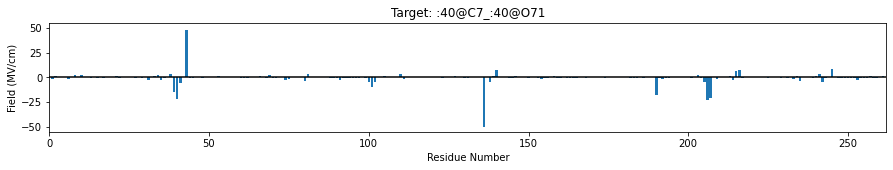

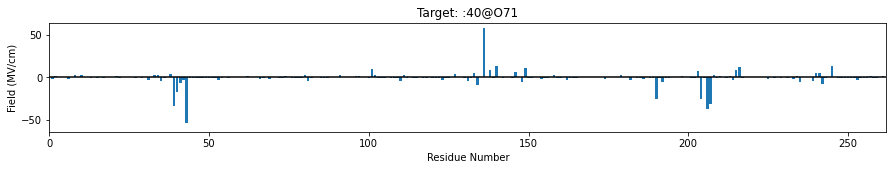

In [ ]:
#@title Load the calculated fields
import matplotlib.pyplot as plt 
import numpy as np
plt.rcParams["figure.figsize"]=[15,2]
for Target in FIELDS:
    
    # Only protein residues, no Total, Solvent, etc.
    x_keys = [i for i in list(FIELDS[Target]) if len(i.split("_"))==2] 
    
    #get x and y data
    y = np.array([np.mean(FIELDS[Target][x_key]) for x_key in x_keys])
    x = np.array([int(x_key.split("_")[-1]) for x_key in x_keys])
    
    #plot data
    plt.bar(x, y)
    plt.axhline(0,c= "k")
    plt.title(f"Target: {Target}")
    plt.xlabel("Residue Number")
    plt.ylabel("Field (MV/cm)")
    plt.xlim(0, len(x) + 1)
    plt.ylim(-max(abs(y))*1.1, max(abs(y))*1.1)
    plt.show()